In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import trimesh

scene = trimesh.Scene()

In [3]:
import my_code.diffusion_training_sign_corr.data_loading as data_loading

train_dataset = data_loading.get_val_dataset(
    'FAUST_r', 'train', 200, canonicalize_fmap=None
    )[1]
test_dataset = data_loading.get_val_dataset(
    'FAUST_r', 'test', 200, canonicalize_fmap=None
)[1]

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Loading base dataset: 100%|████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.97it/s]


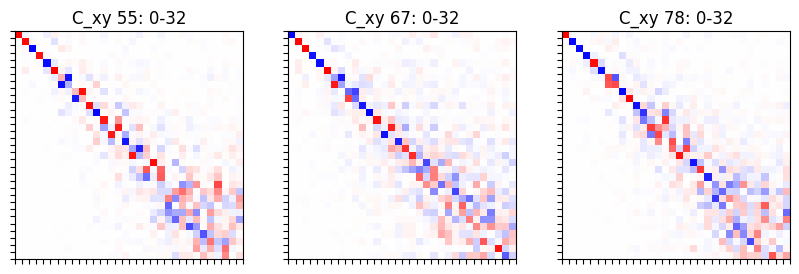

In [5]:
import my_code.utils.plotting_utils as plotting_utils

l = 0
h = 32

fig, axs = plt.subplots(1, 3, figsize=(10, 5))

plotting_utils.plot_Cxy(fig, axs[0], train_dataset[55]['second']['C_gt_xy'][0],
                        'C_xy 55', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[1], train_dataset[67]['second']['C_gt_xy'][0],
                        'C_xy 67', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[2], train_dataset[78]['second']['C_gt_xy'][0],
                        'C_xy 78', l, h, show_grid=False, show_colorbar=False)



plt.show()

In [4]:
import networks.diffusion_network as diffusion_network

condition_dim = 0
start_dim = 0

feature_dim = 32
evecs_per_support = 4

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = diffusion_network.DiffusionNet(
    in_channels=feature_dim,
    out_channels=feature_dim // evecs_per_support,
    cache_dir=None,
    input_type='wks',
    k_eig=128,
    n_block=6
    ).to(device)

In [6]:
input_type = 'wks'
net.load_state_dict(torch.load('/home/s94zalek_hpc/shape_matching/my_code/experiments/sign_double_start_0_feat_32_6block_factor4_dataset_SURREAL_train_rot_180_180_180_normal_True_noise_0.0_-0.05_0.05_lapl_mesh_scale_0.9_1.1_wks/40000.pth'))

<All keys matched successfully>

In [7]:
import my_code.sign_canonicalization.training as sign_training

# only keep the train and test meshes with index % 10 == 1
# train_shapes = [train_shapes[i] for i in range(len(train_shapes)) if i % 10 == 1]
# test_shapes = [test_shapes[i] for i in range(len(test_shapes)) if i % 10 == 1]

train_shapes = [train_dataset[i]['second'] for i in range(len(train_dataset))]
test_shapes = [test_dataset[i]['second'] for i in range(len(test_dataset))]

train_diff_folder = '/home/s94zalek_hpc/shape_matching/data_with_smpl_corr/FAUST_r/diffusion'
test_diff_folder = '/home/s94zalek_hpc/shape_matching/data_with_smpl_corr/FAUST_r/diffusion'

In [ ]:
# add 4 random training shapes to trimesh scene

# np.random.shuffle(train_shapes)
scene.geometry.clear()

rand_idx_train = np.random.randint(0, len(train_shapes), 5)
rand_idx_test = np.random.randint(0, len(test_shapes), 5)

for i, idx in enumerate(rand_idx_train):
    scene.add_geometry(trimesh.Trimesh(
        vertices=train_shapes[idx]['verts'] + torch.tensor([i, 0, 0]),
        faces=train_shapes[idx]['faces']))
    
for i, idx in enumerate(rand_idx_test):
    scene.add_geometry(trimesh.Trimesh(
        vertices=test_shapes[idx]['verts'] + torch.tensor([i, -1, 0]),
        faces=test_shapes[idx]['faces']))
    
axis = trimesh.creation.axis(axis_length=1)
scene.add_geometry(axis)
scene.show()

In [8]:
from tqdm import tqdm
import utils.geometry_util as geometry_util
import robust_laplacian
import scipy.sparse.linalg as sla
import utils.geometry_util as geometry_util

tqdm._instances.clear()

# shapes_to_test = test_shapes
# net.cache_dir = test_diff_folder

shapes_to_test = train_shapes
net.cache_dir = train_diff_folder
    
C_xy_pred_list = torch.tensor([])
C_xy_orig_list = torch.tensor([])
prod_with_support_list = torch.tensor([])
supp_vec_list = []
evecs_corrected_list = []

### template shape

data_0 = train_dataset[0]
verts_first = data_0['first']['verts'].unsqueeze(0).to(device)
faces_first = data_0['first']['faces'].unsqueeze(0).to(device)
evecs_first = data_0['first']['evecs'][:, start_dim:start_dim+feature_dim].unsqueeze(0).to(device)
corr_first = data_0['first']['corr']

with torch.no_grad():
    # sign_pred_first = sign_training.predict_sign_change(
    #     net, verts_first, faces_first, evecs_first, 
    #     evecs_cond=None, input_type=input_type)[0]
    sign_pred_first = torch.ones_like(evecs_first[0, 0, :])


### other shapes

for i in range(len(train_dataset)):
    data_0 = train_dataset[i]

    verts_second = data_0['second']['verts'].unsqueeze(0).to(device)
    faces_second = data_0['second']['faces'].unsqueeze(0).to(device)

    evecs_second = data_0['second']['evecs'][:, start_dim:start_dim+feature_dim].unsqueeze(0).to(device)
    corr_second = data_0['second']['corr']

    C_gt_xy = data_0['second']['C_gt_xy'][0]

    # predict the sign change
    with torch.no_grad():
        sign_pred_second, supp_vec, prod_with_support = sign_training.predict_sign_change(
            net, verts_second, faces_second, evecs_second, 
            evecs_cond=None, input_type=input_type)

    evecs_second_corrected = evecs_second.cpu()[0] * torch.sign(sign_pred_second).cpu()
    # normalize the eigenvectors in 0th dimension
    evecs_second_corrected = evecs_second_corrected / torch.norm(evecs_second_corrected, dim=0, keepdim=True)

    C_xy_pred = torch.linalg.lstsq(
        evecs_second.cpu()[0, corr_second] * torch.sign(sign_pred_second).cpu(),
        evecs_first.cpu()[0, corr_first] * torch.sign(sign_pred_first).cpu()
        ).solution
    
    C_xy_pred_list = torch.cat([C_xy_pred_list, C_xy_pred.unsqueeze(0)])
    C_xy_orig_list = torch.cat([C_xy_orig_list, C_gt_xy.unsqueeze(0)])
    prod_with_support_list = torch.cat([prod_with_support_list, prod_with_support.cpu()])
    supp_vec_list.append(supp_vec)
    evecs_corrected_list.append(evecs_second_corrected)


In [ ]:
import my_code.utils.plotting_utils as plotting_utils

rand_idx = np.random.choice(len(C_xy_pred_list), 3, replace=False)

l = 0
h = 32

fig, axs = plt.subplots(3, 3, figsize=(10, 10))

plotting_utils.plot_Cxy(fig, axs[0, 0], prod_with_support_list[rand_idx[0]],
                        f'prod_with_support {rand_idx[0]}', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[0, 1], C_xy_pred_list[rand_idx[0]],
                        f'C_xy_pred {rand_idx[0]}', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[0, 2], C_xy_orig_list[rand_idx[0]],
                        f'C_xy_orig {rand_idx[0]}', l, h, show_grid=False, show_colorbar=False)

plotting_utils.plot_Cxy(fig, axs[1, 0], prod_with_support_list[rand_idx[1]],
                        f'prod_with_support {rand_idx[1]}', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[1, 1], C_xy_pred_list[rand_idx[1]],
                        f'C_xy_pred {rand_idx[1]}', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[1, 2], C_xy_orig_list[rand_idx[1]],
                        f'C_xy_orig {rand_idx[1]}', l, h, show_grid=False, show_colorbar=False)

plotting_utils.plot_Cxy(fig, axs[2, 0], prod_with_support_list[rand_idx[2]],
                        f'prod_with_support {rand_idx[2]}', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[2, 1], C_xy_pred_list[rand_idx[2]],
                        f'C_xy_pred {rand_idx[2]}', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[2, 2], C_xy_orig_list[rand_idx[2]],
                        f'C_xy_orig {rand_idx[2]}', l, h, show_grid=False, show_colorbar=False)


plt.show()

In [11]:
# apply standard scaling and PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd


def apply_pca(input_data, title, pca_components, use_scaler, show_ratio, show_pairplot):

    if use_scaler:
        scaler = StandardScaler()
        input_data_scaled = scaler.fit_transform(input_data.reshape(input_data.shape[0], -1))
    else:
        input_data_scaled = input_data.reshape(input_data.shape[0], -1)
        
    pca = PCA(n_components=32)
    input_data_pca = pca.fit_transform(input_data_scaled)


    if show_ratio:
        fig, axs = plt.subplots(1, 1, figsize=(5, 4))

        # plot explained variance
        axs.plot(pca.explained_variance_ratio_, '.-')
        axs.set_title(f'{title}: explained variance ratio')

    if show_pairplot:
        pca_df = pd.DataFrame(input_data_pca[:, :pca_components],
                              columns=[f'PCA_{i}' for i in range(pca_components)])
        # pca_df['name'] = names_y
        pca_df['body_type'] = [i // 10 for i in range(input_data_pca.shape[0])]
        # pca_df['pose'] = [i % 10 for i in range(C_xy_pred_list_pca.shape[0])]


        # use numbers as markers
        sns.pairplot(pca_df, diag_kind='kde', hue='body_type', palette='tab10')

    if show_ratio or show_pairplot:
        plt.show()



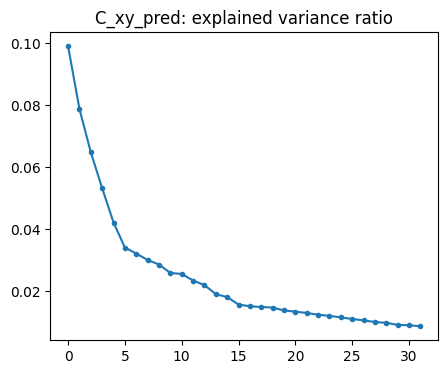

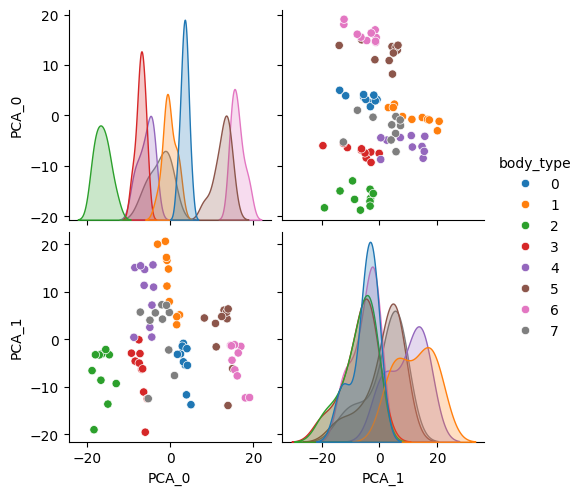

In [52]:
apply_pca(C_xy_pred_list, title='C_xy_pred', pca_components=2, show_ratio=True, show_pairplot=True)

In [ ]:
apply_pca(C_xy_orig_list, 'C_xy_orig', show_ratio=False, show_pairplot=True)

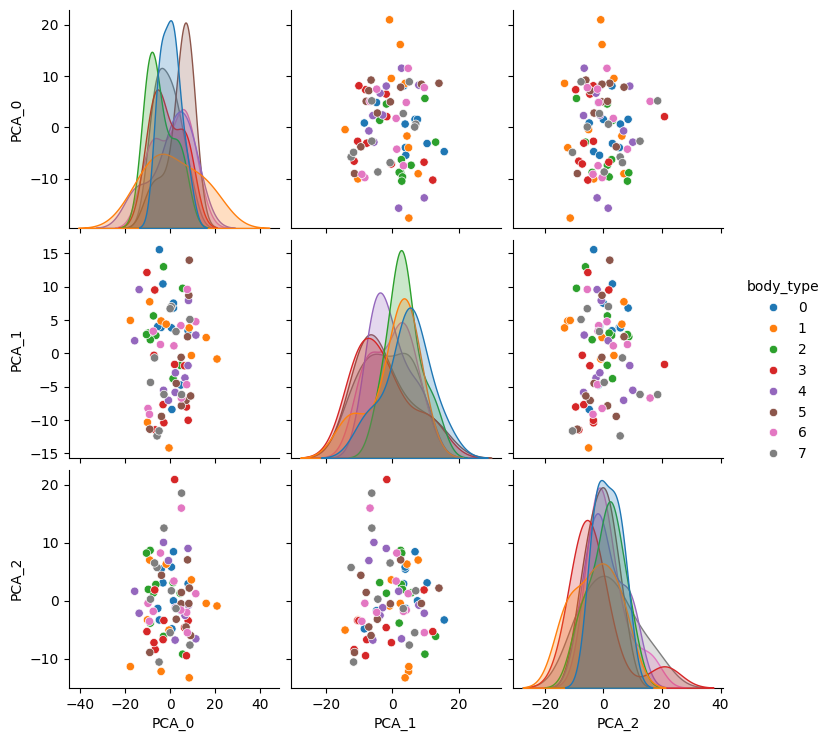

In [38]:
apply_pca(prod_with_support_list, 'prod_with_support', pca_components=3, use_scaler=True, show_ratio=False, show_pairplot=True)

In [ ]:
for i in range(len(supp_vec_list)):
    print(supp_vec_list[i].shape)

In [ ]:
# supp_vec_list.transpose(1, 2) @ supp_vec_list]
supp_vec_norm_list = [supp_vec_list[i].transpose(1, 2) @ supp_vec_list[i] for i in range(len(supp_vec_list))]
supp_vec_norm_list = torch.cat(supp_vec_norm_list).cpu()
apply_pca(supp_vec_norm_list, 'supp_vec_norm', pca_components=3, use_scaler=True, show_ratio=True, show_pairplot=True)

In [74]:
evecs_corrected_norm_list.reshape(evecs_corrected_norm_list.shape[0], -1).shape

torch.Size([80, 1024])

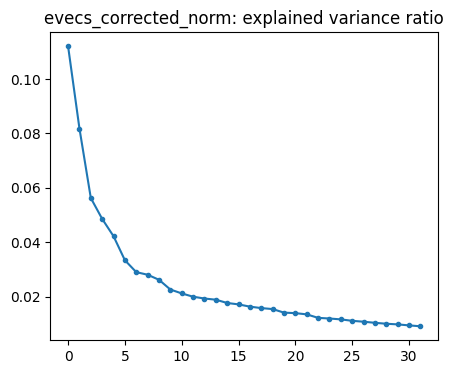

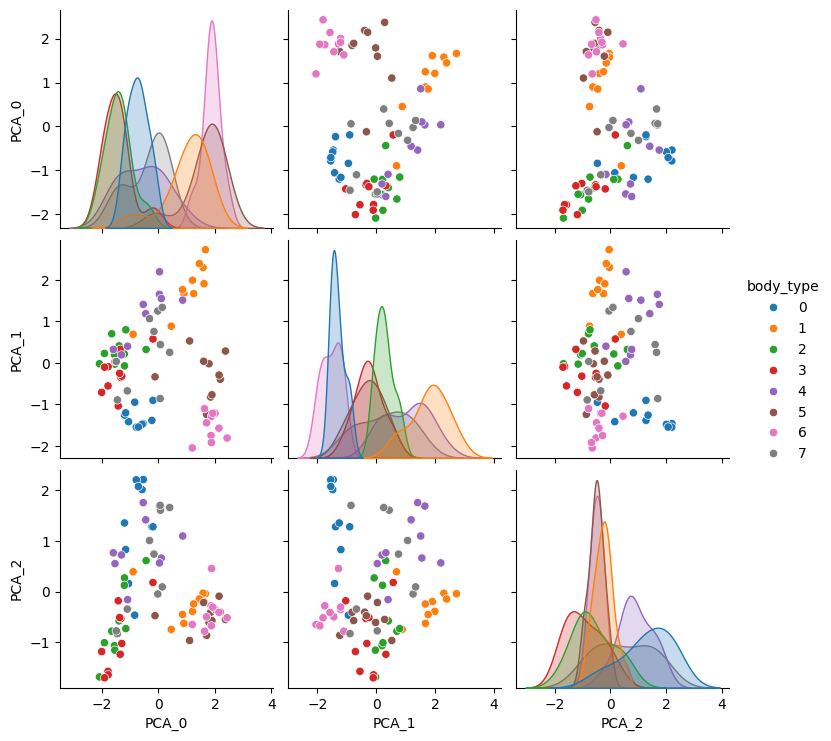

In [85]:
# supp_vec_list.transpose(1, 2) @ supp_vec_list]
# supp_vec_norm_list = [supp_vec_list[i].transpose(1, 2) @ supp_vec_list[i] for i in range(len(supp_vec_list))]
# supp_vec_norm_list = torch.cat(supp_vec_norm_list).cpu()

evecs_corrected_norm_list = [evecs_corrected_list[i].transpose(0, 1) @ evecs_corrected_list[i] for i in range(len(evecs_corrected_list))]
evecs_corrected_norm_list = torch.stack(evecs_corrected_norm_list).cpu()

# set all elements on main diagonal to 1
# for i in range(evecs_corrected_norm_list.shape[0]):
#     evecs_corrected_norm_list[i, torch.arange(evecs_corrected_norm_list.shape[1]), torch.arange(evecs_corrected_norm_list.shape[1])] = 1

scaler = StandardScaler()

evecs_corrected_norm_list_scaled = scaler.fit_transform(evecs_corrected_norm_list.reshape(evecs_corrected_norm_list.shape[0], -1))
evecs_corrected_norm_list_scaled = evecs_corrected_norm_list_scaled.reshape(evecs_corrected_norm_list.shape)

apply_pca(evecs_corrected_norm_list, 'evecs_corrected_norm', pca_components=3, use_scaler=False, show_ratio=True, show_pairplot=True)

In [ ]:
import my_code.utils.plotting_utils as plotting_utils

rand_idx = np.random.choice(len(C_xy_pred_list), 3, replace=False)

l = 0
h = 32

fig, axs = plt.subplots(3, 3, figsize=(12, 10))

plotting_utils.plot_Cxy(fig, axs[0, 0], evecs_corrected_norm_list[rand_idx[0]],
                        f'evecs_corrected_norm {rand_idx[0]}', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[0, 1], C_xy_pred_list[rand_idx[0]],
                        f'C_xy_pred {rand_idx[0]}', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[0, 2], C_xy_orig_list[rand_idx[0]],
                        f'C_xy_orig {rand_idx[0]}', l, h, show_grid=False, show_colorbar=False)

plotting_utils.plot_Cxy(fig, axs[1, 0], evecs_corrected_norm_list[rand_idx[1]],
                        f'evecs_corrected_norm {rand_idx[1]}', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[1, 1], C_xy_pred_list[rand_idx[1]],
                        f'C_xy_pred {rand_idx[1]}', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[1, 2], C_xy_orig_list[rand_idx[1]],
                        f'C_xy_orig {rand_idx[1]}', l, h, show_grid=False, show_colorbar=False)

plotting_utils.plot_Cxy(fig, axs[2, 0], evecs_corrected_norm_list[rand_idx[2]],
                        f'evecs_corrected_norm {rand_idx[2]}', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[2, 1], C_xy_pred_list[rand_idx[2]],
                        f'C_xy_pred {rand_idx[2]}', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[2, 2], C_xy_orig_list[rand_idx[2]],
                        f'C_xy_orig {rand_idx[2]}', l, h, show_grid=False, show_colorbar=False)


# axs_0 = axs[0, 0].imshow(evecs_corrected_norm_list_scaled[rand_idx[0]],
#                          cmap='bwr', vmin=-3, vmax=3)
# plt.colorbar(axs_0, ax=axs[0, 0])

# axs_1 = axs[1, 0].imshow(evecs_corrected_norm_list_scaled[rand_idx[1]],
#                          cmap='bwr', vmin=-3, vmax=3)
# plt.colorbar(axs_1, ax=axs[1, 0])

# axs_2 = axs[2, 0].imshow(evecs_corrected_norm_list_scaled[rand_idx[2]],
#                          cmap='bwr', vmin=-3, vmax=3)
# plt.colorbar(axs_2, ax=axs[2, 0])


plt.show()

In [47]:

evecs_orig_norm_list = []
evecs_orig_list = []

for i in range(len(train_dataset)):
    evecs_second = train_dataset[i]['second']['evecs'][:, start_dim:start_dim+feature_dim]
    
    evecs_second_norm = evecs_second / torch.norm(evecs_second, dim=0, keepdim=True)
    
    evecs_orig_norm_list.append(evecs_second_norm.transpose(0, 1) @ evecs_second_norm)
    
    evecs_orig_list.append(evecs_second)
    
evecs_orig_norm_list = torch.stack(evecs_orig_norm_list).cpu()

apply_pca(evecs_orig_norm_list, 'evecs_orig_norm', pca_components=3, show_ratio=True, show_pairplot=True)



TypeError: apply_pca() missing 1 required positional argument: 'use_scaler'

In [ ]:
import my_code.utils.plotting_utils as plotting_utils

rand_idx = np.random.choice(len(C_xy_pred_list), 3, replace=False)

l = 0
h = 32

fig, axs = plt.subplots(3, 4, figsize=(15, 12))

plotting_utils.plot_Cxy(fig, axs[0, 0], evecs_corrected_norm_list[rand_idx[0]],
                        f'evecs_corrected_norm {rand_idx[0]}', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[0, 1], evecs_orig_norm_list[rand_idx[0]],
                        f'evecs_orig_norm {rand_idx[0]}', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[0, 2], C_xy_pred_list[rand_idx[0]],
                        f'C_xy_pred {rand_idx[0]}', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[0, 3], C_xy_orig_list[rand_idx[0]],
                        f'C_xy_orig {rand_idx[0]}', l, h, show_grid=False, show_colorbar=False)

plotting_utils.plot_Cxy(fig, axs[1, 0], evecs_corrected_norm_list[rand_idx[1]],
                        f'evecs_corrected_norm {rand_idx[1]}', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[1, 1], evecs_orig_norm_list[rand_idx[1]],
                        f'evecs_orig_norm {rand_idx[1]}', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[1, 2], C_xy_pred_list[rand_idx[1]],
                        f'C_xy_pred {rand_idx[1]}', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[1, 3], C_xy_orig_list[rand_idx[1]],
                        f'C_xy_orig {rand_idx[1]}', l, h, show_grid=False, show_colorbar=False)

plotting_utils.plot_Cxy(fig, axs[2, 0], evecs_corrected_norm_list[rand_idx[2]],
                        f'evecs_corrected_norm {rand_idx[2]}', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[2, 1], evecs_orig_norm_list[rand_idx[2]],
                        f'evecs_orig_norm {rand_idx[2]}', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[2, 2], C_xy_pred_list[rand_idx[2]],
                        f'C_xy_pred {rand_idx[2]}', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[2, 3], C_xy_orig_list[rand_idx[2]],
                        f'C_xy_orig {rand_idx[2]}', l, h, show_grid=False, show_colorbar=False)

plt.show()

In [101]:
# get the size of /home/s94zalek_hpc/shape_matching/data_with_smpl_corr/FAUST_r/diffusion/2eea12d909bd7d93b9f68e2a96013d11b7c51ca4_0.npz
import os

print(os.path.getsize('/home/s94zalek_hpc/shape_matching/data_with_smpl_corr/FAUST_r/diffusion/2eea12d909bd7d93b9f68e2a96013d11b7c51ca4_0.npz') / 1024 / 1024, 'MB')

5.155857086181641 MB


# Product of evecs by mass matrix

In [13]:
train_dataset[0]['second']['mass'].shape, evecs_corrected_list[0].shape

(torch.Size([4999]), torch.Size([4999, 32]))

In [ ]:
torch.diag

In [ ]:
# supp_vec_list.transpose(1, 2) @ supp_vec_list]
# supp_vec_norm_list = [supp_vec_list[i].transpose(1, 2) @ supp_vec_list[i] for i in range(len(supp_vec_list))]
# supp_vec_norm_list = torch.cat(supp_vec_norm_list).cpu()

evecs_corrected_norm_list = []
for i in range(len(evecs_corrected_list)):
    evecs_corrected_norm_list.append(
        evecs_corrected_list[i].transpose(0, 1) @\
        torch.diag(train_dataset[i]['second']['mass']) @\
        evecs_corrected_list[i] 
    )
evecs_corrected_norm_list = torch.stack(evecs_corrected_norm_list).cpu()

# set all elements on main diagonal to 1
# for i in range(evecs_corrected_norm_list.shape[0]):
#     evecs_corrected_norm_list[i, torch.arange(evecs_corrected_norm_list.shape[1]), torch.arange(evecs_corrected_norm_list.shape[1])] = 1

scaler = StandardScaler()

# evecs_corrected_norm_list_scaled = scaler.fit_transform(evecs_corrected_norm_list.reshape(evecs_corrected_norm_list.shape[0], -1))
# evecs_corrected_norm_list_scaled = evecs_corrected_norm_list_scaled.reshape(evecs_corrected_norm_list.shape)

apply_pca(evecs_corrected_norm_list, 'evecs_corrected_norm by mass', pca_components=3, use_scaler=False, show_ratio=True, show_pairplot=True)

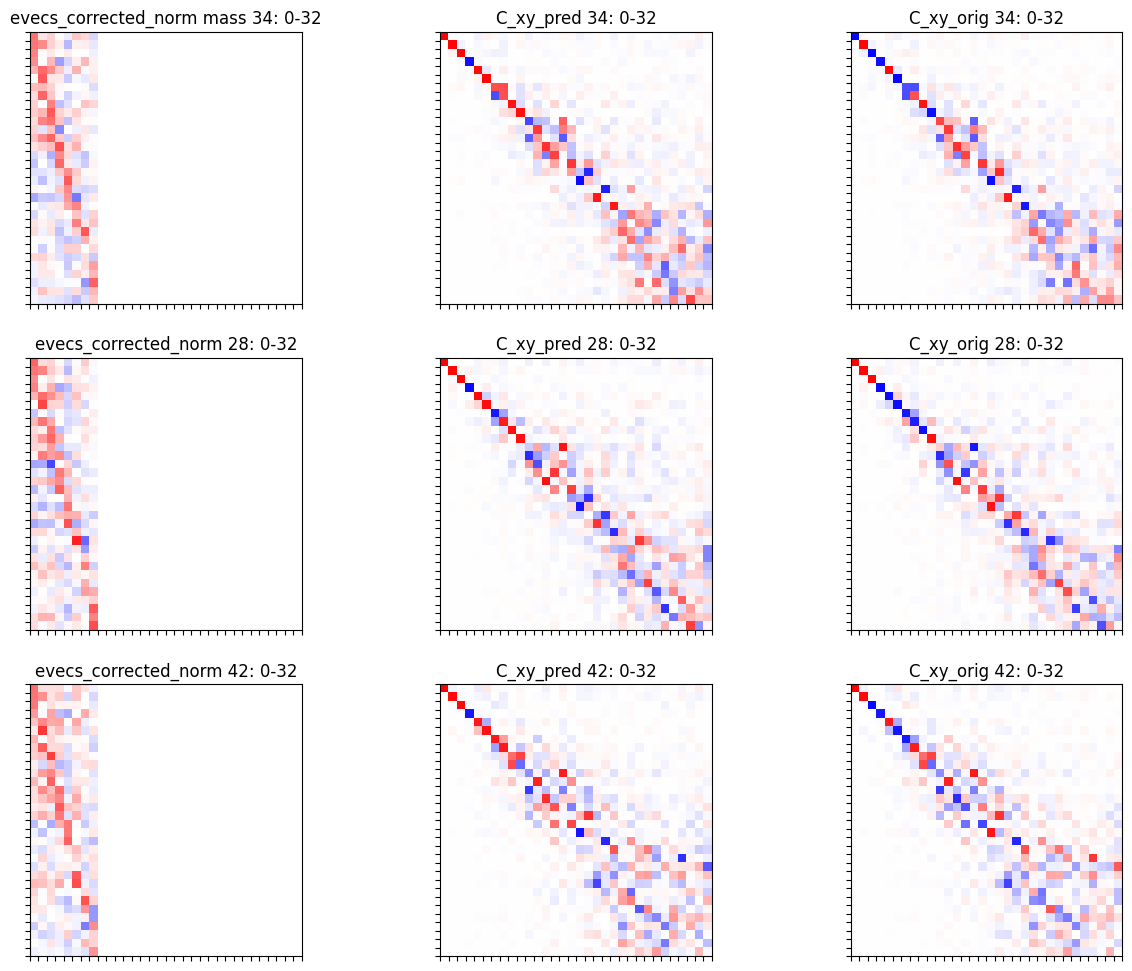

In [54]:
import my_code.utils.plotting_utils as plotting_utils

rand_idx = np.random.choice(len(C_xy_pred_list), 3, replace=False)

l = 0
h = 32

fig, axs = plt.subplots(3, 3, figsize=(15, 12))

plotting_utils.plot_Cxy(fig, axs[0, 0], prod_with_support_mass_list[rand_idx[0]][0],
                        f'evecs_corrected_norm mass {rand_idx[0]}', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[0, 1], C_xy_pred_list[rand_idx[0]],
                        f'C_xy_pred {rand_idx[0]}', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[0, 2], C_xy_orig_list[rand_idx[0]],
                        f'C_xy_orig {rand_idx[0]}', l, h, show_grid=False, show_colorbar=False)

plotting_utils.plot_Cxy(fig, axs[1, 0], prod_with_support_mass_list[rand_idx[1]][0],
                        f'evecs_corrected_norm {rand_idx[1]}', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[1, 1], C_xy_pred_list[rand_idx[1]],
                        f'C_xy_pred {rand_idx[1]}', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[1, 2], C_xy_orig_list[rand_idx[1]],
                        f'C_xy_orig {rand_idx[1]}', l, h, show_grid=False, show_colorbar=False)

plotting_utils.plot_Cxy(fig, axs[2, 0], prod_with_support_mass_list[rand_idx[2]][0],
                        f'evecs_corrected_norm {rand_idx[2]}', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[2, 1], C_xy_pred_list[rand_idx[2]],
                        f'C_xy_pred {rand_idx[2]}', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[2, 2], C_xy_orig_list[rand_idx[2]],
                        f'C_xy_orig {rand_idx[2]}', l, h, show_grid=False, show_colorbar=False)

plt.show()

In [28]:
evecs_corrected_norm_list[0]

tensor([[ 2.0004e-04,  6.5370e-13, -1.1462e-12,  ..., -2.4158e-12,
         -1.1369e-12,  4.4409e-12],
        [ 2.0179e-12,  1.4383e-04, -3.7202e-12,  ...,  5.7554e-13,
          4.1229e-12,  1.8070e-12],
        [-1.1462e-12, -7.3581e-12,  1.4490e-04,  ..., -1.9001e-12,
          1.2620e-13, -4.4616e-13],
        ...,
        [-2.7711e-12,  9.6456e-13, -1.1042e-12,  ...,  1.8961e-04,
         -3.1548e-12, -3.1051e-12],
        [-3.0269e-12,  4.2375e-12, -3.7828e-13,  ..., -3.0127e-12,
          1.3123e-04, -7.3967e-12],
        [ 1.7693e-12,  1.2386e-12, -5.1011e-13,  ..., -2.0535e-12,
         -4.6647e-12,  1.7567e-04]])

In [ ]:
plt_0 = plt.imshow(evecs_corrected_norm_list[25])
plt.colorbar(plt_0)

plt.show()

# Product with support and mass matrix

In [11]:
prod_with_support_mass_list = []
for i in range(len(evecs_corrected_list)):
    prod_with_support_mass_list.append(
        # evecs_orig_list[i].transpose(0, 1) @\
            evecs_corrected_list[i].transpose(0, 1) @\
        # torch.diag(train_dataset[i]['second']['mass']) @\
        supp_vec_list[i].cpu() 
    )
prod_with_support_mass_list = torch.stack(prod_with_support_mass_list).cpu()


# apply_pca(prod_with_support_mass_list, 'prod_with_support_mass_list', pca_components=3, use_scaler=True, show_ratio=True, show_pairplot=True)

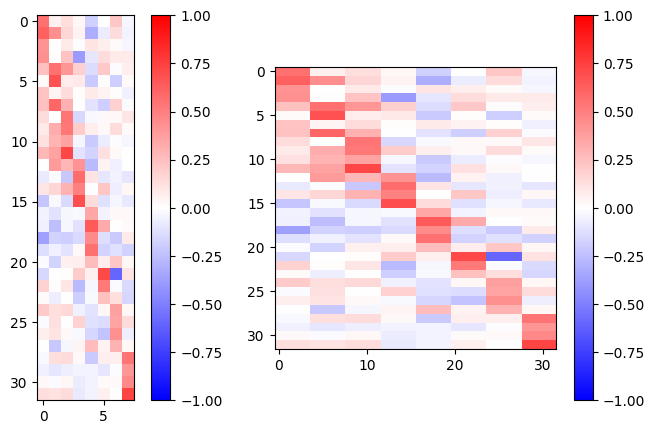

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

plt_1 = axs[0].imshow(prod_with_support_mass_list[25][0], cmap='bwr', vmin=-1, vmax=1)
plt.colorbar(plt_1)

plt_2 = axs[1].imshow(
    torch.repeat_interleave(prod_with_support_mass_list[25][0], 4, dim=1),
                      cmap='bwr', vmin=-1, vmax=1)
plt.colorbar(plt_2)

plt.show()


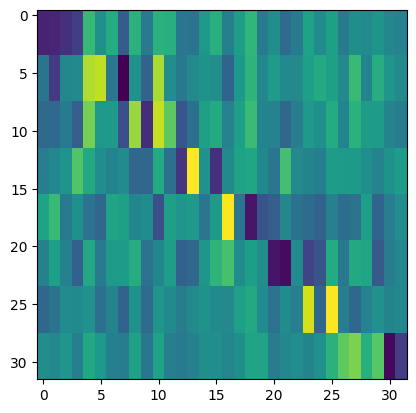

In [10]:
plt.imshow(prod_with_support_list[0])